In [43]:
import geopandas as gpd
import rioxarray
from rasterio.features import geometry_mask
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [44]:
base_path = Path("/Users/robynhaggis/Documents/Geospatial_analysis/Inputs")

In [30]:
jamaica_metric_grid_crs = "EPSG:3448"

In [31]:
slope_dem = rioxarray.open_rasterio(base_path / "reprojected_DEM_EPSG3448.tif")
print("DEM CRS:", slope_dem.rio.crs)
land_use = gpd.read_file(base_path / "2013_landuse_LandCover.shp").to_crs(slope_dem.rio.crs)

DEM CRS: EPSG:3448


In [32]:
# Step 1: Extract slope data from the DEM and convert to degrees (assuming you have the DEM as a numpy array)
slope_degrees = np.arctan(np.sqrt(np.gradient(slope_dem[0].values, axis=0)**2 + np.gradient(slope_dem[0].values, axis=1)**2)) * (180 / np.pi)

In [33]:
# Step 2: Filter the slope data (e.g., between 20° and 36°)
slope_filtered = np.where((slope_degrees >= 20) & (slope_degrees <= 36), slope_degrees, np.nan)

In [39]:
# Step 3: Rasterize the land use data into the same grid as the DEM (if not already done)
land_use_rasterized = np.zeros_like(slope_filtered, dtype=np.uint8)  # Initialize with zeros
land_use.head()

,OBJECTID,Classify,Hectares,Shape_Leng,LU_CODE,Shape_Le_1,Shape_Area,Area new,geometry
0,1,Bare Rock,0.219042,217.030317,BR,217.030317,2190.423461,2190.423,"POLYGON ((695760.683 632592.443, 695841.393 63..."
1,2,Bare Rock,0.489814,306.713227,BR,306.713227,4898.144181,4898.144,"POLYGON ((695594.285 632593.327, 695704.227 63..."
2,3,Bare Rock,0.653918,363.027264,BR,363.027264,6539.178784,6539.179,"POLYGON ((696433.566 632824.876, 696362.105 63..."
3,4,Bare Rock,1.518056,661.429856,BR,661.429856,15180.560352,15180.560,"POLYGON ((694375.817 633191.930, 694383.735 63..."
4,5,Bare Rock,0.144238,259.855721,BR,259.855721,1442.383465,1442.383,"POLYGON ((698016.285 633459.921, 698130.536 63..."


In [36]:
# Loop through land use polygons and assign values to the rasterized land use map
for _, row in land_use.iterrows():
    geom = row['geometry']
    mask = geometry_mask([geom], transform=slope_dem.rio.transform(), invert=True, out_shape=slope_filtered.shape)
    land_use_rasterized[mask] = row['Classify']  # Replace 'classify' with the actual column name for land use type

ValueError: invalid literal for int() with base 10: 'Bare Rock'

In [40]:
# Check the unique land use types in the 'Classify' column
unique_land_use_types = land_use['Classify'].unique()

# Print the unique land use types
print("Unique land use types:", unique_land_use_types)

Unique land use types: ['Bare Rock' 'Fields: Herbaceous crops, fallow, cultivated vegetables'
 'Fields: Pasture,Human disturbed, grassland' 'Herbaceous Wetland'
 'Mangrove Forest' 'Fields: Bare Land' 'Open dry forest - Short'
 'Open dry forest - Tall (Woodland/Savanna)'
 'Plantation: Tree crops, shrub crops, sugar cane, banana' 'Quarry'
 'Water Body' 'Buildings and other infrastructures'
 'Fields and Secondary Forest' 'Bamboo and Fields' 'Bauxite Extraction'
 'Disturbed broadleaved forest (Secondary Forest)' 'Fields  and Bamboo'
 'Bamboo and Secondary Forest' 'Hardwood Plantation: Euculytus'
 'Hardwood Plantation: Mixed' 'Swamp Forest'
 'Fields or Secondary Forest/Pine Plantation' 'Hardwood Plantation: Mahoe'
 'Hardwood Plantation: Mahogany' 'Bamboo'
 'Closed broadleaved forest (Primary Forest)' 'Secondary Forest']


AttributeError: 'AxesImage' object has no attribute 'legend_elements'

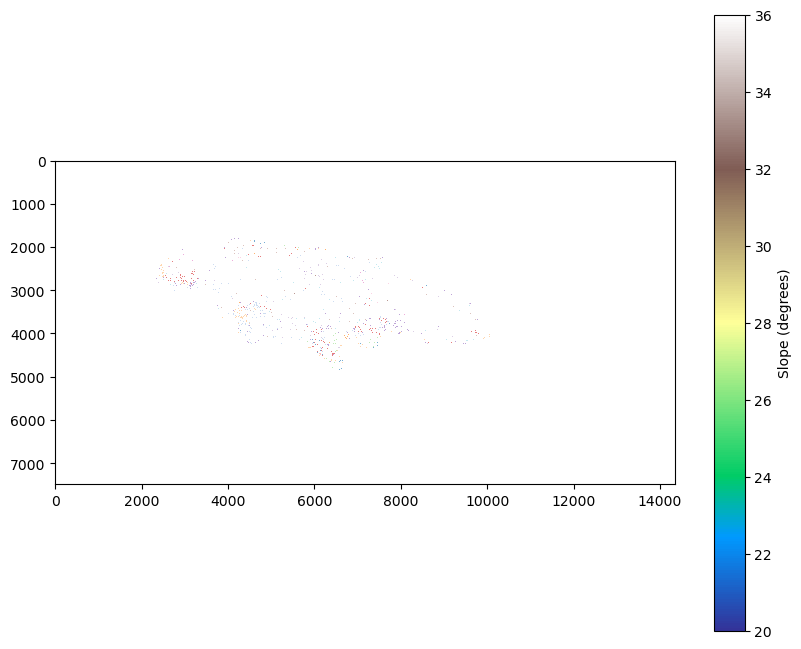

In [41]:
import numpy as np
from rasterio.features import geometry_mask

# Step 1: Create a mapping of land use types to integers
land_use_mapping = {
    'Bare Rock': 1,
    'Fields: Herbaceous crops, fallow, cultivated vegetables': 2,
    'Fields: Pasture,Human disturbed, grassland': 3,
    'Herbaceous Wetland': 4,
    'Mangrove Forest': 5,
    'Fields: Bare Land' 'Open dry forest - Short': 6,
    'Open dry forest - Tall (Woodland/Savanna)': 7,
    'Plantation: Tree crops, shrub crops, sugar cane, banana': 8,
    'Quarry': 9,
    'Water Body': 10,
    'Buildings and other infrastructures': 11,
    'Fields and Secondary Forest': 12,
    'Bamboo and Fields': 13,
    'Bauxite Extraction': 14,
    'Disturbed broadleaved forest (Secondary Forest)': 15,
    'Fields  and Bamboo': 16,
    'Bamboo and Secondary Forest': 17,
    'Hardwood Plantation: Euculytus': 18,
    'Hardwood Plantation: Mixed': 19,
    'Swamp Forest': 20,
    'Fields or Secondary Forest/Pine Plantation': 21,
    'Hardwood Plantation: Mahoe': 22,
    'Hardwood Plantation: Mahogany': 23,
    'Bamboo': 24,
    'Closed broadleaved forest (Primary Forest)': 25,
    'Secondary Forest': 26,
}

# Step 2: Initialize a raster array for land use
land_use_rasterized = np.zeros_like(slope_filtered, dtype=np.uint8)

# Step 3: Loop through land use polygons and assign values to the rasterized land use map
for _, row in land_use.iterrows():
    geom = row['geometry']
    # Create a mask for the land use polygon
    mask = geometry_mask([geom], transform=slope_dem.rio.transform(), invert=True, out_shape=slope_filtered.shape)
    
    # Get the land use type and map it to an integer value
    land_use_type = row['Classify']  # Replace 'Classify' with your actual column name for land use type
    land_use_value = land_use_mapping.get(land_use_type, 0)  # Default to 0 if land use type is not found in the mapping
    
    # Assign the land use value to the rasterized array
    land_use_rasterized[mask] = land_use_value

# Now land_use_rasterized contains integer values for each land use type
# Step 4: Mask the land use raster by the filtered slope
land_use_slope_filtered = np.where(np.isnan(slope_filtered), np.nan, land_use_rasterized)

# Step 5: Plot the filtered slope and land use
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the slope data
cax = ax.imshow(slope_filtered, cmap='terrain', vmin=20, vmax=36)
fig.colorbar(cax, ax=ax, label="Slope (degrees)")

# Plot the land use data over the slope
land_use_overlay = ax.imshow(land_use_slope_filtered, alpha=0.6, cmap='tab20', interpolation='none')

# Add a legend for land use types (if applicable)
handles, labels = land_use_overlay.legend_elements()
ax.legend(handles, labels, title="Land Use Type", loc='upper left')

# Show the plot
ax.set_title("Land Use by Slope (Filtered by 20° to 36°)")
plt.show()


AttributeError: 'AxesImage' object has no attribute 'legend_elements'

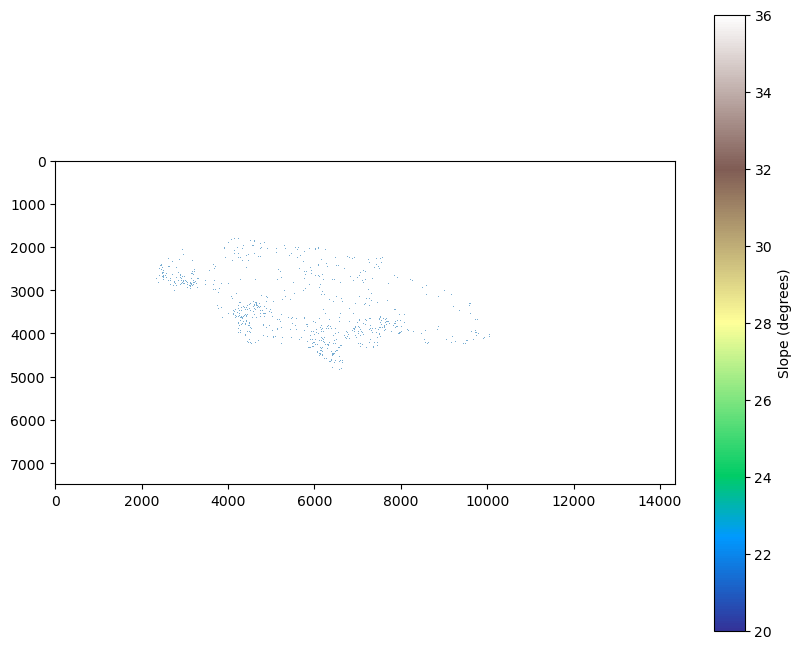

In [38]:
# Step 5: Plot the filtered slope and land use
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the slope data
cax = ax.imshow(slope_filtered, cmap='terrain', vmin=20, vmax=36)
fig.colorbar(cax, ax=ax, label="Slope (degrees)")

# Plot the land use data over the slope
land_use_overlay = ax.imshow(land_use_slope_filtered, alpha=0.6, cmap='tab20', interpolation='none')

# Add a legend for land use types (if applicable)
handles, labels = land_use_overlay.legend_elements()
ax.legend(handles, labels, title="Land Use Type", loc='upper left')

# Show the plot
ax.set_title("Land Use by Slope (Filtered by 20° to 36°)")
plt.show()